# **Project: AirBnB Price Prediction**


## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import confusion_matrix as conMatrix
from sklearn.metrics import classification_report as ClassR
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from uszipcode import Zipcode, SearchEngine
search = SearchEngine(simple_zipcode=True)

%matplotlib inline

## 2. Importing data and Data cleaning (i.e. handling missing data, etc)

### 2.a) Importing Data

In [2]:
train_df = pd.read_csv("./airbnb-listings-in-major-us-cities-deloitte-ml/train.csv")
test_df = pd.read_csv("./airbnb-listings-in-major-us-cities-deloitte-ml/test.csv")

### 2.b) Check for missing values

In [3]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count
27,bedrooms,91
28,beds,131
13,host_has_profile_pic,188
14,host_identity_verified,188
16,host_since,188
6,bathrooms,200
26,zipcode,966
22,neighbourhood,6872
25,thumbnail_url,8216
18,last_review,15827


### 2.c) Handling missing values in both train and test dataframe

In [4]:
# 'bathrooms'
train_df['bathrooms'] = train_df['bathrooms'].fillna(0)
test_df['bathrooms'] = test_df['bathrooms'].fillna(0)

# 'bedrooms'
train_df['bedrooms'] = train_df['bedrooms'].fillna(0)
test_df['bedrooms'] = test_df['bedrooms'].fillna(0)

# 'beds' 
train_df['beds'] = train_df['beds'].fillna(0)
test_df['beds'] = test_df['beds'].fillna(0)

# 'host_has_profile_pic'
train_df.loc[train_df.host_has_profile_pic == 't', 'host_has_profile_pic'] = 1
train_df.loc[train_df.host_has_profile_pic == 'f', 'host_has_profile_pic'] = 0
train_df['host_has_profile_pic'] = train_df['host_has_profile_pic'].fillna(0)
test_df.loc[test_df.host_has_profile_pic == 't', 'host_has_profile_pic'] = 1
test_df.loc[test_df.host_has_profile_pic == 'f', 'host_has_profile_pic'] = 0
test_df['host_has_profile_pic'] = test_df['host_has_profile_pic'].fillna(0)

# 'neighbourhood'
train_df['neighbourhood'] = train_df['neighbourhood'].fillna('Unknown')
test_df['neighbourhood'] = test_df['neighbourhood'].fillna('Unknown')

# 'review_scores_rating'
train_df['review_scores_rating'] = train_df['review_scores_rating'].fillna(0)
test_df['review_scores_rating'] = test_df['review_scores_rating'].fillna(0)

# 'host_response_rate'
train_df['host_response_rate'] = train_df['host_response_rate'].str.replace('%','')
train_df['host_response_rate'] = train_df['host_response_rate'].fillna('0')
train_df['host_response_rate'] = pd.to_numeric(train_df['host_response_rate'])
test_df['host_response_rate'] = test_df['host_response_rate'].str.replace('%','')
test_df['host_response_rate'] = test_df['host_response_rate'].fillna('0')
test_df['host_response_rate'] = pd.to_numeric(test_df['host_response_rate'])

# 'thumbnai_url'
train_df['thumbnail_url'] = train_df['thumbnail_url'].fillna('Unknown')
test_df['thumbnail_url'] = test_df['thumbnail_url'].fillna('Unknown')

# 'last_review'
train_df['last_review'] = train_df['last_review'].fillna('00-00-00')
test_df['last_review'] = test_df['last_review'].fillna('00-00-00')

# 'first_review'
train_df['first_review'] = train_df['first_review'].fillna('00-00-00')
test_df['first_review'] = test_df['first_review'].fillna('00-00-00')

# 'host_since'
train_df['host_since'] = train_df['host_since'].fillna('00-00-00')
test_df['host_since'] = test_df['host_since'].fillna('00-00-00')

# 'host_identity_verified'
train_df.loc[train_df.host_identity_verified == 't', 'host_identity_verified'] = 1
train_df.loc[train_df.host_identity_verified == 'f', 'host_identity_verified'] = 0
train_df['host_identity_verified'] = train_df['host_identity_verified'].fillna(0)
test_df.loc[test_df.host_identity_verified == 't', 'host_identity_verified'] = 1
test_df.loc[test_df.host_identity_verified == 'f', 'host_identity_verified'] = 0
test_df['host_identity_verified'] = test_df['host_identity_verified'].fillna(0)

# 'zipcode', ***this might take some time, but works perfect***
train_df['zipcode'] = train_df['zipcode'].fillna(0)
train_df.loc[train_df.zipcode == ' ', 'zipcode'] = 0
idx = train_df.index[train_df['zipcode']==0].tolist()
for i in idx:
    lat = train_df['latitude'][i]
    lon = train_df['longitude'][i]
    result = np.max(search.by_coordinates(lat, lon, radius=30, returns=5))
    train_df['zipcode'][i]=result.values()[0]    
test_df['zipcode'] = test_df['zipcode'].fillna(0)
test_df.loc[test_df.zipcode == ' ', 'zipcode'] = 0
idx = test_df.index[test_df['zipcode']==0].tolist()
for i in idx:
    lat = test_df['latitude'][i]
    lon = test_df['longitude'][i]
    result = np.max(search.by_coordinates(lat, lon, radius=30, returns=5))
    test_df['zipcode'][i]=result.values()[0]    

C:\Users\sanke_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\sanke_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# Again check for missing values in the test dataframe
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


In [6]:
train_df['int_price'] = np.exp(train_df['log_price'])

## 3. Data Visualization
### 3.a) Plot 1: Integer Pricing per City

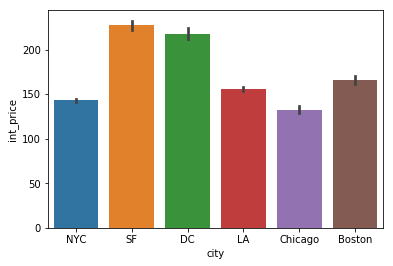

In [7]:
plot1 = sns.barplot(x='city',y='int_price',data=train_df)
fig = plot1.get_figure()
fig.savefig('./plot1.png')

### 3.b) Plot 2: Average pricing for Property Type w.r.to City

In [9]:
train_df.pivot_table(values='int_price',index='property_type',columns='city')

city,Boston,Chicago,DC,LA,NYC,SF
property_type,,,,,,
Apartment,167.716744,122.763368,199.836840,124.099510,139.850646,215.796375
Bed & Breakfast,105.705882,111.000000,143.823529,97.254310,134.021053,150.196078
Boat,358.800000,367.666667,82.666667,181.103448,146.000000,404.000000
Boutique hotel,149.000000,215.500000,142.375000,104.000000,347.812500,202.142857
Bungalow,NaN,99.333333,172.500000,133.029326,144.166667,227.000000
Cabin,NaN,NaN,110.000000,111.180328,176.666667,154.714286
Camper/RV,NaN,NaN,NaN,129.321429,NaN,160.400000
Casa particular,NaN,NaN,NaN,80.000000,NaN,NaN
Castle,NaN,NaN,199.000000,283.750000,175.000000,228.333333


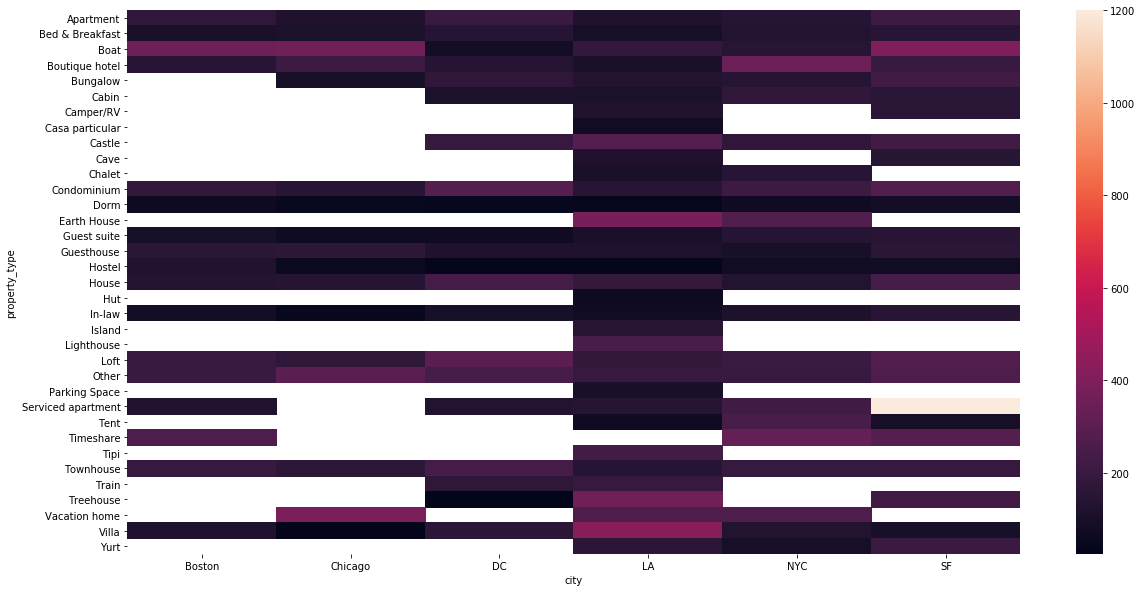

In [10]:
plt.figure(figsize=(20,10))
pivot_df = train_df.pivot_table(values='int_price',index='property_type',columns='city')
plot2 = sns.heatmap(pivot_df)
fig = plot2.get_figure()
fig.savefig('./plot2.png')

### 3.c) Plot 3: Price variation for Property Type as per Accomodates

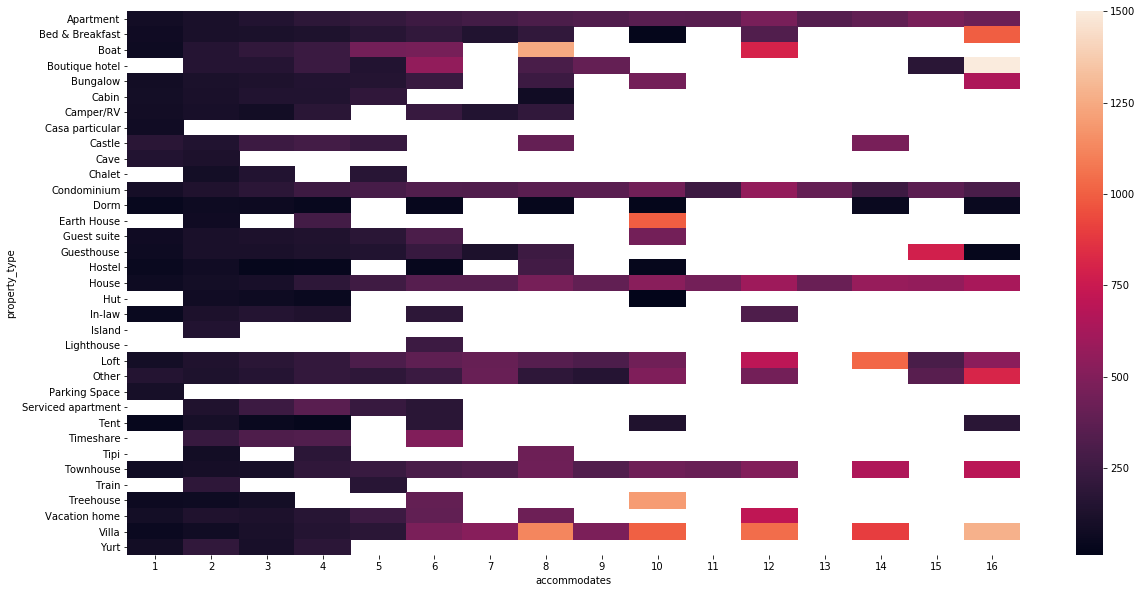

In [11]:
plt.figure(figsize=(20,10))
pivot_df = train_df.pivot_table(values='int_price',index='property_type',columns='accommodates')
plot3 = sns.heatmap(pivot_df)
fig = plot3.get_figure()
fig.savefig('./plot3.png')

## 4. Data Preprocessing

In [12]:
# For simplicity, save the Dataframe obtained after filling missing values and use it for further process
train_df.to_csv('./airbnb-listings-in-major-us-cities-deloitte-ml/new_train.csv', encoding='utf-8', index=False)
test_df.to_csv('./airbnb-listings-in-major-us-cities-deloitte-ml/new_test.csv', encoding='utf-8', index=False)

In [13]:
# importing 'new_train.csv' and 'new_test.csv' 
Rtrain_df = pd.read_csv('./airbnb-listings-in-major-us-cities-deloitte-ml/new_train.csv')
Rtest_df = pd.read_csv('./airbnb-listings-in-major-us-cities-deloitte-ml/new_test.csv')

### 4.a) Dropping out features that has no effect on pricing

In [14]:
Rtrain_df.drop(['int_price'], axis =1, inplace=True)

Rtrain_df.drop(['id'], axis =1, inplace=True)
Rtest_df.drop(['id'], axis =1, inplace=True)

Rtrain_df.drop(['log_price'], axis =1, inplace=True)

Rtrain_df.drop(['neighbourhood'], axis =1, inplace=True)
Rtest_df.drop(['neighbourhood'], axis =1, inplace=True)

Rtrain_df.drop(['description'], axis =1, inplace=True)
Rtest_df.drop(['description'], axis =1, inplace=True)

Rtrain_df.drop(['first_review'], axis =1, inplace=True)
Rtest_df.drop(['first_review'], axis =1, inplace=True)

Rtrain_df.drop(['last_review'], axis =1, inplace=True)
Rtest_df.drop(['last_review'], axis =1, inplace=True)

Rtrain_df.drop(['host_since'], axis =1, inplace=True)
Rtest_df.drop(['host_since'], axis =1, inplace=True)

Rtrain_df.drop(['thumbnail_url'], axis =1, inplace=True)
Rtest_df.drop(['thumbnail_url'], axis =1, inplace=True)

Rtrain_df.drop(['zipcode'], axis =1, inplace=True)
Rtest_df.drop(['zipcode'], axis =1, inplace=True)

Rtrain_df.drop(['amenities'], axis =1, inplace=True)
Rtest_df.drop(['amenities'], axis =1, inplace=True)

Rtrain_df.drop(['name'], axis =1, inplace=True)
Rtest_df.drop(['name'], axis =1, inplace=True)

Rtrain_df.drop(['latitude'], axis =1, inplace=True)
Rtest_df.drop(['latitude'], axis =1, inplace=True)

Rtrain_df.drop(['longitude'], axis =1, inplace=True)
Rtest_df.drop(['longitude'], axis =1, inplace=True)

Rtrain_df.drop(['instant_bookable'], axis =1, inplace=True)
Rtest_df.drop(['instant_bookable'], axis =1, inplace=True)

In [15]:
Rtrain_df.dtypes

property_type              object
room_type                  object
accommodates                int64
bathrooms                 float64
bed_type                   object
cancellation_policy        object
cleaning_fee                 bool
city                       object
host_has_profile_pic        int64
host_identity_verified      int64
host_response_rate          int64
number_of_reviews           int64
review_scores_rating      float64
bedrooms                  float64
beds                      float64
dtype: object

In [16]:
rtrain_df = Rtrain_df.copy()
rtest_df = Rtest_df.copy()
print(rtrain_df.shape)
print(rtest_df.shape)

(74111, 15)
(25458, 15)


### 4.b) One Hot Encoding required features from Train and Test Data 

In [17]:
def one_hot(train_df,test_df,columns):
    
    for i,column in enumerate(columns):
        Xtrain = train_df[str(column)].T
        Xtest = test_df[str(column)].T
        
        # train_df
        lb=LabelBinarizer()
        lb.fit(Xtrain)
        X_classes = len(lb.classes_)
        Xenc = lb.transform(Xtrain)
        Xtrain_enc = pd.DataFrame(data = Xenc, columns = lb.classes_)
        train_df.drop([str(column)], axis =1, inplace=True)
        
        # test_df
        Xenc = lb.transform(Xtest)
        Xtest_enc = pd.DataFrame(data = Xenc, columns = lb.classes_)
        test_df.drop([str(column)], axis =1, inplace=True)
        
        print('Number of classes in '+str(column)+ ' = '+ str(X_classes))
        train_df = pd.concat((train_df,Xtrain_enc),axis=1)
        test_df = pd.concat((test_df,Xtest_enc),axis=1) 
    return train_df,test_df

In [18]:
r_train_df , r_test_df = one_hot(rtrain_df,rtest_df,['city','property_type', 'room_type', 'bed_type', 'cancellation_policy', 'host_response_rate'])

Number of classes in city = 6
Number of classes in property_type = 35
Number of classes in room_type = 3
Number of classes in bed_type = 5
Number of classes in cancellation_policy = 5
Number of classes in host_response_rate = 80


In [19]:
print(r_test_df.shape)
print(r_train_df.shape)

(25458, 143)
(74111, 143)


## 5. Feature Selection
### 5.a) Principal Component Analysis (PCA):

In [20]:
pca = PCA()
pca_fit = pca.fit_transform(r_train_df)
pca_fit.shape

(74111, 143)

### 5.b) Stepwise Forward Feature Selection:

In [324]:
# linearReg = LinearRegression()
# stepfs = sfs(lr, k_features=100, forward=True, floating=False, scoring='neg_mean_squared_error', cv=10)
# stepfs = sfs.fit(new_df2, train_df['log_price'])


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

<Figure size 1440x2880 with 0 Axes>

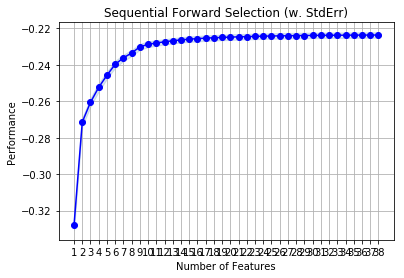

In [345]:
# metric_dict = sfs.get_metric_dict()
# plt.figure(figsize=(20,40))
# fig = plot_sfs(metric_dict, kind='std_err')
# plt.title('Sequential Forward Selection (w. StdErr)')
# plt.grid()
# plt.show()

## 6. Model Implementation
### 6.a) Linear Regression

In [21]:
X = pca_fit
y = train_df['log_price']

In [22]:
kfold = KFold(n_splits=10,random_state=56,shuffle=True)
average = 0
average1 = 0
for train_idx, test_idx in kfold.split(X,y):    
    X_train, X_CV = X[train_idx], X[test_idx]
    y_train, y_CV = y[train_idx], y[test_idx]
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
        
    pred_CV = lr.predict(X_CV)
    MSE = mse(y_CV, pred_CV)
    average = average + MSE

    score = lr.score(X_CV, y_CV)
    average1 = average1 + score
    
    print('R square score = ',score)
    print('MSE = ',MSE)

MSE_AVG = average/10
Rscore_AVG = average1/10
print('*---------------------------*')
print('Average Rscore = ', Rscore_AVG)
print('Average MSE = ',MSE_AVG)

R square score =  0.5654012746245745
MSE =  0.22192318944278713
R square score =  0.5633148730897317
MSE =  0.22458644011037973
R square score =  -131590731668546.31
MSE =  66091322332642.16
R square score =  0.5453933377616134
MSE =  0.2297517249453151
R square score =  0.5734704726216235
MSE =  0.21939141230162723
R square score =  0.5574586725719507
MSE =  0.2253363724737585
R square score =  -1.1335300251717886e+19
MSE =  5.882620688230396e+18
R square score =  0.5691584675030794
MSE =  0.22833979911279698
R square score =  0.5675132988821144
MSE =  0.22265125246968148
R square score =  0.5611401820887367
MSE =  0.23100361874309633
*---------------------------*
Average Rscore =  -1.1335431842449555e+18
Average MSE =  5.882686779552728e+17


### 6.b) Ridge Regression:

In [23]:
kfold = KFold(n_splits=10,random_state=56,shuffle=True)
average = 0
average1 = 0

for train_idx, test_idx in kfold.split(X,y):    
    
    X_train, X_CV = X[train_idx], X[test_idx]
    y_train, y_CV = y[train_idx], y[test_idx]
    
    ridge = Ridge()
    ridge.fit(X_train, y_train)
    
    pred_CV = ridge.predict(X_CV)
    MSE = mse(y_CV, pred_CV)
    average = average + MSE
    
    score = ridge.score(X_CV, y_CV)
    average1 = average1 + score
    
    print('R square score = ',score)
    print('MSE = ',MSE)

MSE_AVG = average/10
Rscore_AVG = average1/10
print('*---------------------------*')
print('Average Rscore = ', Rscore_AVG)
print('Average MSE = ', MSE_AVG)

R square score =  0.5654560665468353
MSE =  0.22189521053389058
R square score =  0.5633846563828384
MSE =  0.22455055067789798
R square score =  0.5602826721635872
MSE =  0.22084761807149897
R square score =  0.5454209231397408
MSE =  0.2297377836885441
R square score =  0.5735818788292762
MSE =  0.21933410896465463
R square score =  0.5575218206199788
MSE =  0.22530421829698555
R square score =  0.5811691171337385
MSE =  0.2173584432441897
R square score =  0.5690972644447891
MSE =  0.22837223585108937
R square score =  0.5675170062627048
MSE =  0.22264934384930152
R square score =  0.561272329964992
MSE =  0.23093405977146503
*---------------------------*
Average Rscore =  0.5644703735488481
Average MSE =  0.22409835729495176


### 6.c) Lasso Regression:

In [24]:
kfold = KFold(n_splits=10,random_state=56,shuffle=True)
average = 0
average1 = 0

for train_idx, test_idx in kfold.split(X,y):    
    
    X_train, X_CV = X[train_idx], X[test_idx]
    y_train, y_CV = y[train_idx], y[test_idx]
    
    lasso = Lasso(0.0001)
    lasso.fit(X_train, y_train)
        
    pred_CV = lasso.predict(X_CV)
    MSE = mse(y_CV, pred_CV)
    average = average + MSE
    
    score = lasso.score(X_CV, y_CV)
    average1 = average1 + score
    
    print('R square score = ',score)
    print('MSE = ',MSE)

MSE_AVG = average/10
Rscore_AVG = average1/10
print('*---------------------------*')
print('Average Rscore = ', Rscore_AVG)
print('Average MSE = ', MSE_AVG)

R square score =  0.5654415756275892
MSE =  0.22190261016676868
R square score =  0.5629981681267104
MSE =  0.22474932095020472
R square score =  0.5600607762377265
MSE =  0.2209590650934465
R square score =  0.5447123738571393
MSE =  0.2300958743929014
R square score =  0.5731701348429818
MSE =  0.21954589522764817
R square score =  0.5577467483071019
MSE =  0.2251896880012959
R square score =  0.5804463874292832
MSE =  0.21773351444804107
R square score =  0.5688152471056503
MSE =  0.22852170097389693
R square score =  0.5670218191034142
MSE =  0.22290427432678897
R square score =  0.56111105352176
MSE =  0.23101895121170193
*---------------------------*
Average Rscore =  0.5641524284159356
Average MSE =  0.22426208947926943


## 7. Grid Search Technique

In [33]:
parameters = {"alpha":np.logspace(-2,2,50)}
lasso_grid = GridSearchCV(lasso, parameters, cv=10) 
lasso_grid.fit(X,y)

print('Hyper Parameters for Lasso:\n',lasso_grid.best_params_)
print('Score for Hyper Parameters from Grid Search:',lasso_grid.best_score_)
lasso_grid.cv_results_

Best Hyper Parameters for Log Regression:
 {'alpha': 0.01}


## 8. Predicting price for Test Dataset

In [25]:
# implementing Model on entire train dataset and predicting prices for test dataset
pca0 = PCA()
pca0.fit(r_train_df)
X_train = pca0.transform(r_train_df)
y_train = train_df['log_price']

X_test = pca0.transform(r_test_df)

In [26]:
lasso = Lasso(0.0001)
lasso.fit(X_train, y_train)

# Prices predicted for test dataset is given by 'price_predicted'
price_predicted = lasso.predict(X_test)

In [27]:
print(price_predicted)

[4.12293926 4.97952909 4.4763032  ... 4.73559085 5.16852667 4.30827414]
